# Exploration of cluster 511, layer 21, activation threshold 1.5, 100 batch graph gen, 5000 cap PCA

In [33]:
%load_ext autoreload
%autoreload 2
import logging
import os
import re
from os.path import join as pj

import matplotlib.pyplot as plt
import pandas as pd

from sae_cooccurrence.normalised_cooc_functions import (
    neat_sae_id,
)
from sae_cooccurrence.pca import (
    plot_token_pca_and_save,
)
from sae_cooccurrence.streamlit import load_streamlit_config, load_subgraph_data
from sae_cooccurrence.utils.saving_loading import load_npz_files
from sae_cooccurrence.utils.set_paths import get_git_root

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Setup

In [3]:
git_root = get_git_root()

In [20]:
config = load_streamlit_config(
    pj(git_root, "src", "config_pca_streamlit_maxexamples.toml")
)

In [25]:
fs_splitting_cluster = 511
save_figs = True
subgraph_id = fs_splitting_cluster
layer = 21
activation_threshold = 1.5
activation_threshold_safe = str(activation_threshold).replace(".", "_")
batch_size = 100
pca_cap = 5000
model_name = "gemma-2-2b"
sae_release_short = "gemma-scope-2b-pt-res-canonical"
sae_id = "layer_21/width_16k/canonical"
sae_id_neat = neat_sae_id(sae_id)
n_batches_reconstruction = 100
graph_size = 5

In [62]:
results_dir = f"results/{model_name}/{sae_release_short}/{sae_id_neat}"
results_path = pj(git_root, results_dir)
activation_threshold_safe = str(activation_threshold).replace(".", "_")

In [63]:
file_path = pj(
    get_git_root(),
    results_dir,
    f"layer_{layer}_width_16k_canonical_pca_for_streamlit",
    f"{pca_cap}cap_graph_analysis_results_size_{graph_size}_nbatch_{n_batches_reconstruction}.h5",
)

In [64]:
node_df = pd.read_csv(
    pj(results_path, f"dataframes/node_info_df_{activation_threshold_safe}.csv")
)
logging.info(
    f"Loaded node_df from {pj(results_path, f'dataframes/node_info_df_{activation_threshold_safe}.csv')}"
)

overall_feature_activations = load_npz_files(
    results_path, "feature_acts_cooc_activations"
).get(activation_threshold)

# with open(pj(results_path, f"subgraph_objects/activation_{activation_threshold_safe}/subgraph_{subgraph_id}.pkl"), 'rb') as f:
#     subgraph = pickle.load(f)


# Filter for the specific subgraph
fs_splitting_nodes = node_df.query("subgraph_id == @subgraph_id")["node_id"].tolist()

Loading npz files:   0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
pca_prefix = "pca"
figures_path = pj(git_root, f"figures/{model_name}/{sae_release_short}/{sae_id_neat}")
pca_dir = f"{pca_prefix}_{activation_threshold_safe}_subgraph_{subgraph_id}"
pca_path = pj(figures_path, pca_dir)
if not os.path.exists(pca_path):
    os.makedirs(pca_path)

In [22]:
results, pca_df = load_subgraph_data(
    file_path, subgraph_id, config["processing"]["load_options"]
)

In [46]:
# # Save pca_df as CSV
# pca_df_filename = f"pca_df_subgraph_{subgraph_id}.csv"
# pca_df.to_csv(pj(pca_path, pca_df_filename), index=False)

plot_token_pca_and_save(pca_df, pca_path, subgraph_id, color_by="token", save=save_figs)

# plot_pca_explanation_and_save(pca, pca_path, subgraph_id, save=save_figs)

# plot_simple_scatter(results, pca_path, subgraph_id, fs_splitting_nodes, save=save_figs)

# if pca_decoder is not None:
#     pca_decoder, pca_decoder_df = calculate_pca_decoder(sae, fs_splitting_nodes)
#     # Save pca_decoder_df as CSV
#     pca_decoder_df_filename = f"pca_decoder_df_subgraph_{subgraph_id}.csv"
#     pca_decoder_df.to_csv(pj(pca_path, pca_decoder_df_filename), index=False)

#     create_pca_plots_decoder(pca_decoder_df, subgraph_id, pca_path, save=save_figs)

print(f"Processing completed for subgraph ID {subgraph_id}")

AttributeError: 'dict' object has no attribute 'all_graph_feature_acts'

In [57]:
def plot_pca_numbers_before_of(pca_df, pca_path, fs_splitting_cluster, save_figs=False):
    def extract_ordinal_number(context):
        context = context.lower().replace("|", " ")

        # Dictionary for written ordinals
        ordinal_map = {
            "first": 1,
            "second": 2,
            "third": 3,
            "fourth": 4,
            "fifth": 5,
            "sixth": 6,
            "seventh": 7,
            "eighth": 8,
            "ninth": 9,
            "tenth": 10,
            "1st": 1,
            "2nd": 2,
            "3rd": 3,
            "4th": 4,
            "5th": 5,
            "6th": 6,
            "7th": 7,
            "8th": 8,
            "9th": 9,
            "10th": 10,
        }

        # Look for any ordinal form in the text
        for word, value in ordinal_map.items():
            if word in context:
                return value

        # Look for numeric ordinals (1st, 2nd, etc.)
        numeric_ordinal = re.search(r"\b(\d+)(?:st|nd|rd|th)\b", context)
        if numeric_ordinal:
            return int(numeric_ordinal.group(1))

        # Look for plain numbers followed by "of"
        number_of = re.search(r"\b(\d+)\s+of\b", context)
        if number_of:
            return int(number_of.group(1))

        return None

    # Clean context and extract numbers
    pca_df["cleaned_context"] = pca_df["context"].str.replace("<|endoftext|>", "")
    pca_df["ordinal_number"] = pca_df["cleaned_context"].apply(extract_ordinal_number)

    # Create figure
    plt.figure(figsize=(12, 8))

    # Create custom colormap (from cool to warm colors)
    colors = plt.cm.viridis  # type: ignore

    # Plot background points (no ordinal number)
    non_number_mask = pca_df["ordinal_number"].isna()
    plt.scatter(
        pca_df.loc[non_number_mask, "PC2"],
        pca_df.loc[non_number_mask, "PC3"],
        color="lightgrey",
        alpha=0.1,
        s=50,
        label="No ordinal number",
    )

    # Plot points with ordinal numbers using color gradient
    number_mask = ~pca_df["ordinal_number"].isna()
    if number_mask.any():
        scatter = plt.scatter(
            pca_df.loc[number_mask, "PC2"],
            pca_df.loc[number_mask, "PC3"],
            c=pca_df.loc[number_mask, "ordinal_number"],
            cmap=colors,
            alpha=0.6,
            s=50,
        )
        plt.colorbar(scatter, label="Ordinal Number")

    plt.title("PCA Analysis - Ordinal Numbers")
    plt.xlabel("PC2")
    plt.ylabel("PC3")
    plt.tight_layout()

    if save_figs:
        plt.savefig(
            f"{pca_path}/pca_plot_ordinal_numbers_static_{fs_splitting_cluster}.png",
            dpi=300,
            bbox_inches="tight",
        )

    plt.show()
    plt.close()

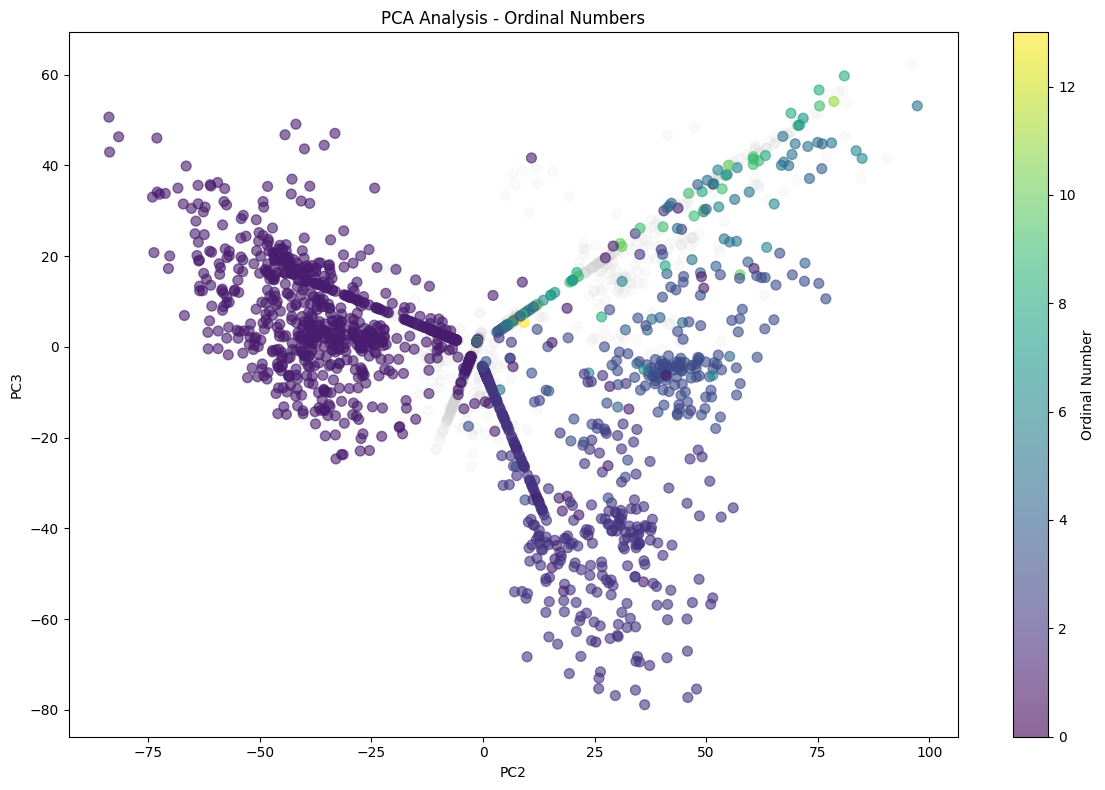

In [58]:
plot_pca_numbers_before_of(pca_df, pca_path, fs_splitting_cluster, save_figs)

In [37]:
def plot_pca_numbers_first_second_third(
    pca_df: pd.DataFrame,
    pca_path: str,
    fs_splitting_cluster: int,
    save_figs: bool = False,
) -> None:
    def extract_ordinal_number_first_second_third(context: str) -> int | None:
        context = context.lower().replace("|", " ")

        # Simplified ordinal map for just first, second, third
        ordinal_map = {
            "first": 1,
            "second": 2,
            "third": 3,
            "1st": 1,
            "2nd": 2,
            "3rd": 3,
        }

        for word, value in ordinal_map.items():
            if word in context:
                return value
        return None

    # Clean context and extract numbers
    pca_df["cleaned_context"] = pca_df["context"].str.replace("<|endoftext|>", "")
    pca_df["ordinal_number_first_second_third"] = pca_df["cleaned_context"].apply(
        extract_ordinal_number_first_second_third
    )

    # Set up colors for each ordinal
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # blue, orange, green
    labels = ["First", "Second", "Third"]

    plt.figure(figsize=(12, 8))

    # Plot background points
    non_number_mask = pca_df["ordinal_number"].isna()
    plt.scatter(
        pca_df.loc[non_number_mask, "PC2"],
        pca_df.loc[non_number_mask, "PC3"],
        color="lightgrey",
        alpha=0.1,
        s=50,
        label="Other tokens",
    )

    # Plot each ordinal number with its own color
    for i, (color, label) in enumerate(zip(colors, labels), start=1):
        mask = pca_df["ordinal_number_first_second_third"] == i
        plt.scatter(
            pca_df.loc[mask, "PC2"],
            pca_df.loc[mask, "PC3"],
            color=color,
            alpha=0.6,
            s=50,
            label=label,
        )

    plt.title("PCA Analysis - First, Second, Third")
    plt.xlabel("PC2")
    plt.ylabel("PC3")
    plt.legend()
    plt.tight_layout()

    if save_figs:
        plt.savefig(
            f"{pca_path}/pca_plot_first_second_third_{fs_splitting_cluster}.png",
            dpi=300,
            bbox_inches="tight",
        )

    plt.show()
    plt.close()

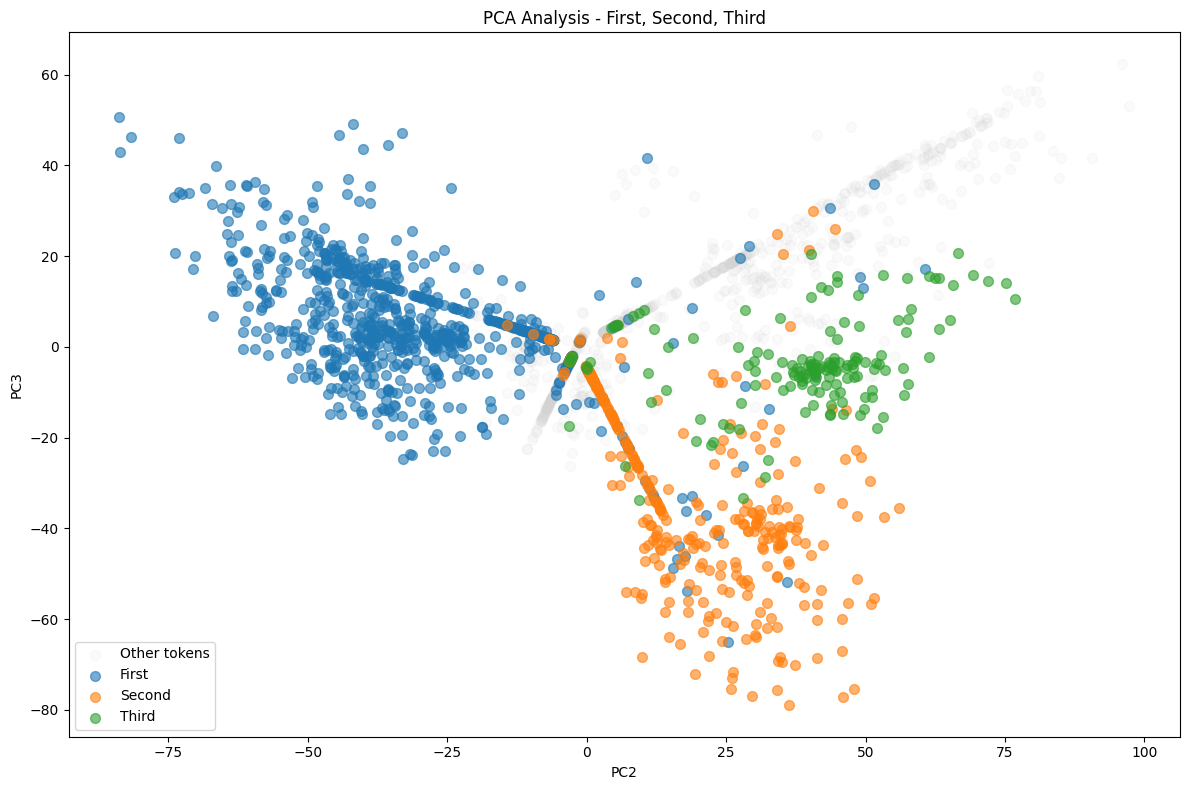

In [38]:
plot_pca_numbers_first_second_third(pca_df, pca_path, fs_splitting_cluster, save_figs)

In [51]:
feature_activations = pd.DataFrame(
    results["all_graph_feature_acts"],
    columns=[f"Feature {i}" for i in fs_splitting_nodes],
)

In [52]:
feature_activations

,Feature 901,Feature 523,Feature 6539,Feature 2795,Feature 7341
0,0.000000,30.665707,0.0,55.275047,57.416225
1,0.000000,0.000000,0.0,10.266323,0.000000
2,9.583035,0.000000,0.0,0.000000,0.000000
3,0.000000,37.949215,0.0,39.217682,77.760513
4,0.000000,34.659458,0.0,35.890244,83.419052
...,...,...,...,...,...
3493,0.000000,0.000000,0.0,24.245592,0.000000
3494,11.270103,0.000000,0.0,0.000000,0.000000
3495,11.024390,17.960491,0.0,51.222672,70.027191
3496,0.000000,0.000000,0.0,0.000000,13.163317


/var/folders/gj/gtktc0xd6vd23yfx6f6gp_lm0000gn/T/ipykernel_8595/3161697320.py:26: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.

/var/folders/gj/gtktc0xd6vd23yfx6f6gp_lm0000gn/T/ipykernel_8595/3161697320.py:26: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.

/var/folders/gj/gtktc0xd6vd23yfx6f6gp_lm0000gn/T/ipykernel_8595/3161697320.py:26: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.

/var/folders/gj/gtktc0xd6vd23yfx6f6gp_lm0000gn/T/ipykernel_8595/3161697320.py:26: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be droppe

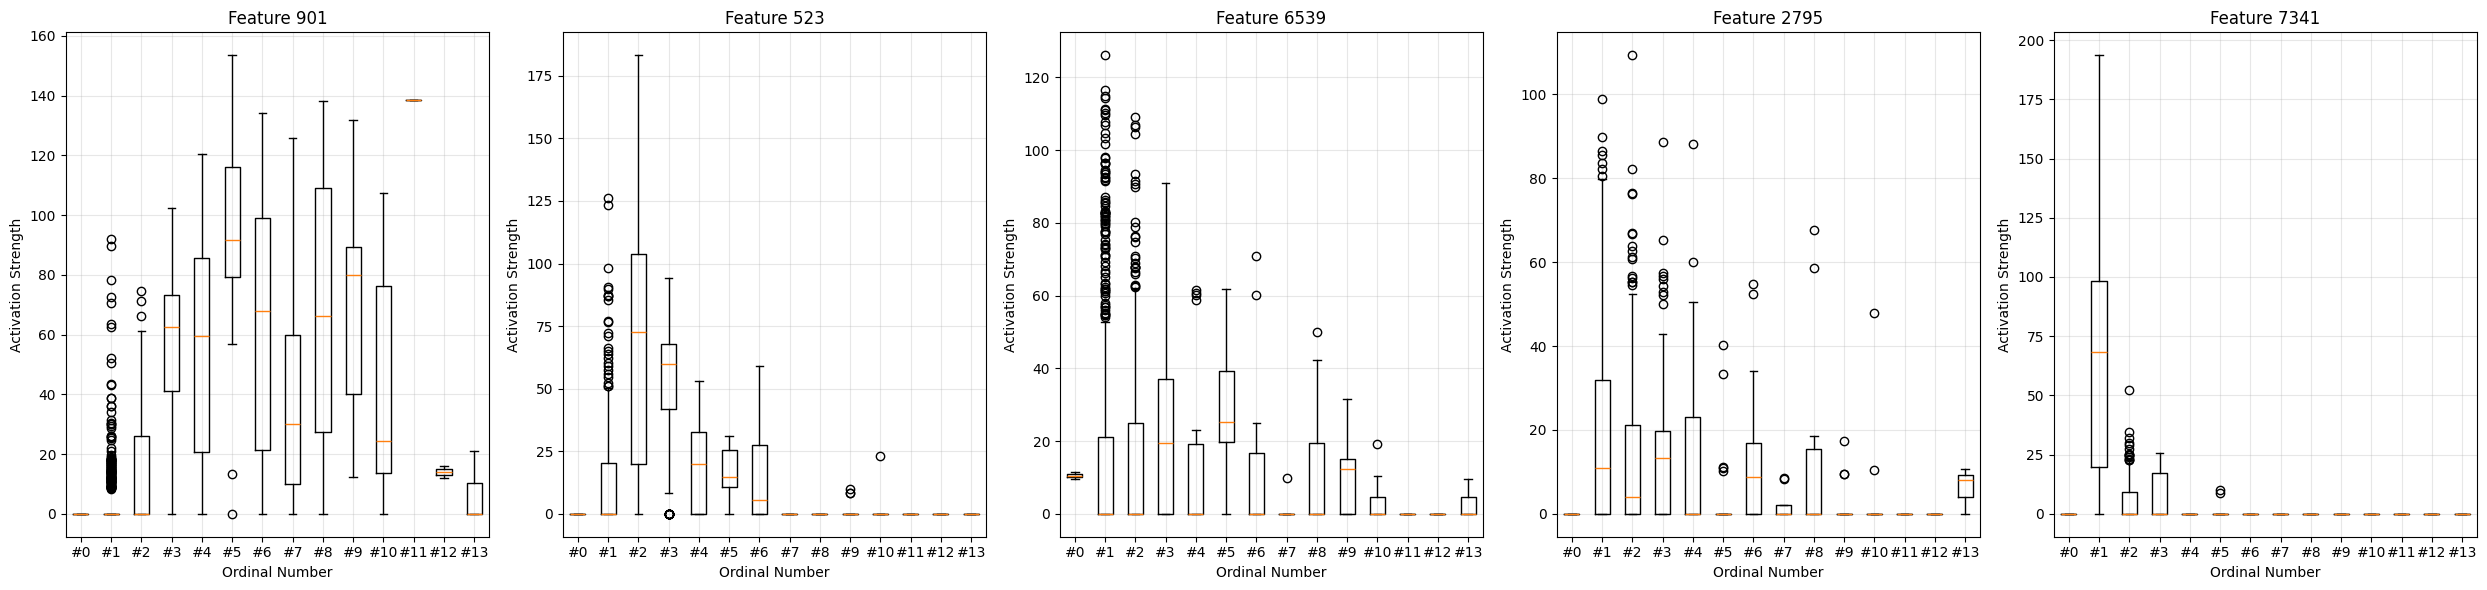

In [59]:
def plot_ordinal_vs_activation_boxplot_per_feature(
    pca_df: pd.DataFrame,
    feature_activations: pd.DataFrame,
    pca_path: str,
    fs_splitting_cluster: int,
    save_figs: bool = False,
) -> None:
    # Filter for rows with ordinal numbers
    df_with_ordinals = pca_df[pca_df["ordinal_number"].notna()].copy()

    # Create a subplot for each feature
    n_features = feature_activations.shape[1]
    fig, axes = plt.subplots(1, n_features, figsize=(5 * n_features, 6))

    for idx, (feature_name, ax) in enumerate(zip(feature_activations.columns, axes)):
        # Get feature activations for this specific feature
        feature_data = [
            feature_activations.loc[
                df_with_ordinals[df_with_ordinals["ordinal_number"] == i].index,
                feature_name,
            ]
            for i in sorted(df_with_ordinals["ordinal_number"].unique())
        ]

        # Create boxplot
        ax.boxplot(
            feature_data,
            labels=[
                f"#{int(i)}"
                for i in sorted(df_with_ordinals["ordinal_number"].unique())
            ],
        )

        ax.set_title(f"{feature_name}")
        ax.set_xlabel("Ordinal Number")
        ax.set_ylabel("Activation Strength")
        ax.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_figs:
        plt.savefig(
            f"{pca_path}/activation_by_ordinal_boxplot_per_feature_{fs_splitting_cluster}.png",
            dpi=300,
            bbox_inches="tight",
        )

    plt.show()
    plt.close()


# Call the function
plot_ordinal_vs_activation_boxplot_per_feature(
    pca_df,
    feature_activations,
    pca_path,
    fs_splitting_cluster,
    save_figs,
)

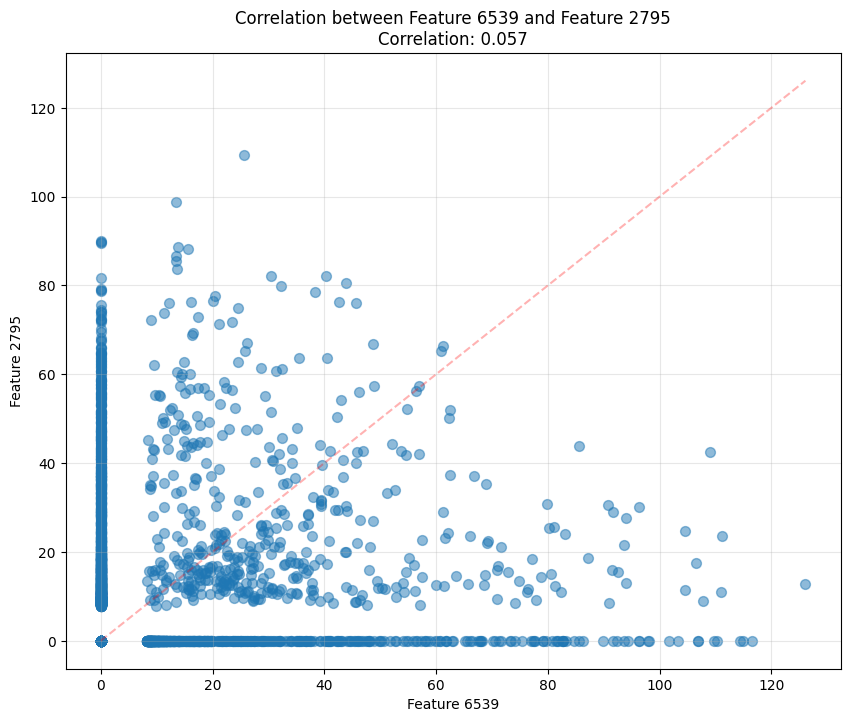

In [60]:
def plot_feature_correlation(
    feature_activations: pd.DataFrame,
    feature1: str,
    feature2: str,
    pca_path: str,
    fs_splitting_cluster: int,
    save_figs: bool = False,
) -> None:
    plt.figure(figsize=(10, 8))

    # Create scatter plot
    plt.scatter(
        feature_activations[feature1],
        feature_activations[feature2],
        alpha=0.5,
        s=50,
    )

    # Add correlation coefficient
    corr = feature_activations[feature1].corr(feature_activations[feature2])
    plt.title(f"Correlation between {feature1} and {feature2}\nCorrelation: {corr:.3f}")

    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.grid(True, alpha=0.3)

    # Add diagonal line for reference
    max_val = max(
        feature_activations[feature1].max(),
        feature_activations[feature2].max(),
    )
    plt.plot([0, max_val], [0, max_val], "r--", alpha=0.3)

    if save_figs:
        plt.savefig(
            f"{pca_path}/feature_correlation_{fs_splitting_cluster}.png",
            dpi=300,
            bbox_inches="tight",
        )

    plt.show()
    plt.close()


# Call the function to plot correlation between features 6539 and 2795
plot_feature_correlation(
    feature_activations,
    "Feature 6539",
    "Feature 2795",
    pca_path,
    fs_splitting_cluster,
    save_figs,
)